# Stacked CNN - LSTM approach for prediction of suicidal ideation on social media

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import emoji
import string
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vectors

from gensim.models import KeyedVectors
import gensim.downloader
import gensim.utils


In [2]:
seed_val = 42

## Setting Up the GPU

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


## Load the dataset

In [4]:
# modify this path to your data path
csv_path = '/kaggle/input/twitter-suicidal-data/twitter-suicidal_data.csv'

raw_df = pd.read_csv(csv_path)
raw_df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [6]:
raw_df.describe()

,intention
count,9119.000000
mean,0.438425
std,0.496221
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
raw_df.shape

(9119, 2)

In [8]:
raw_df['intention'].value_counts()

intention
0    5121
1    3998
Name: count, dtype: int64

<Axes: xlabel='intention'>

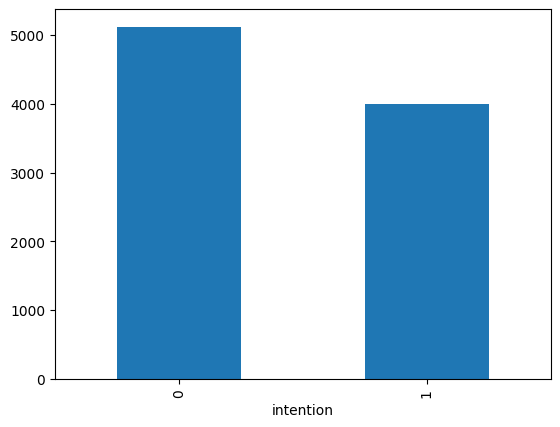

In [9]:
raw_df['intention'].value_counts().plot(kind='bar')

### Remove duplicates

In [10]:
raw_df.duplicated().sum()

333

In [11]:
raw_df = raw_df[~raw_df.duplicated()]

### Word Cloud

In [12]:
non_suicidal_tweets = ' '.join(raw_df[raw_df['intention'] == 1]['tweet'])
suicidal_tweets = ' '.join(raw_df[raw_df['intention'] == 0]['tweet'])

non_suicidal_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(non_suicidal_tweets)
suicidal_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(suicidal_tweets)


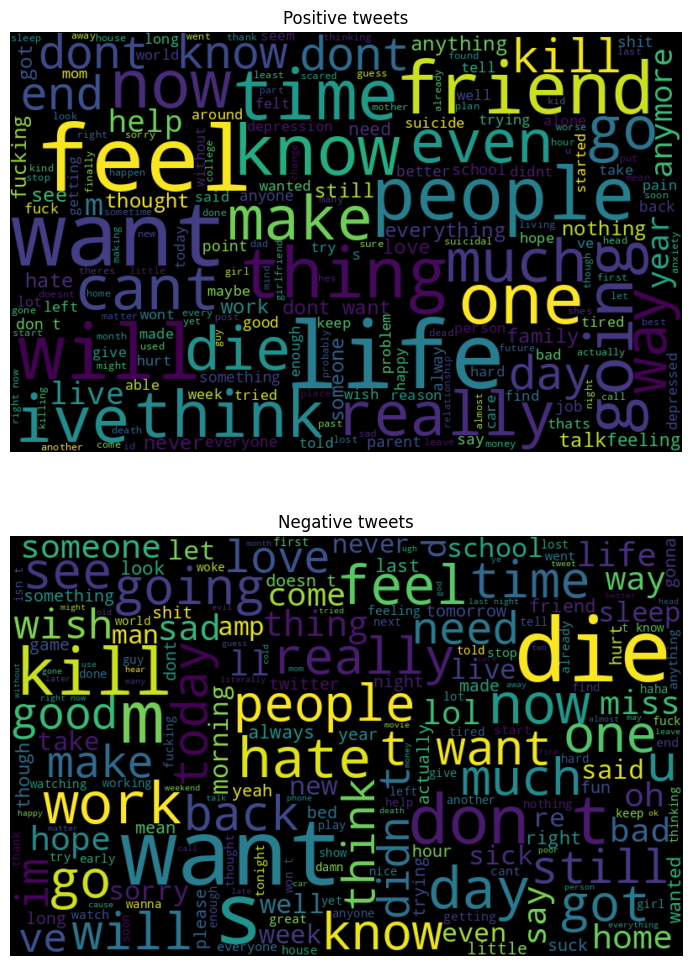

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
ax1.imshow(non_suicidal_wordcloud, interpolation="bilinear")
ax1.set_title('Positive tweets')
ax1.axis('off')
ax2.imshow(suicidal_wordcloud, interpolation="bilinear")
ax2.set_title('Negative tweets')
ax2.axis('off')
plt.show()


## Preprocessing the dataset

Several steps have been employed to preprocess the text involving concatenation of text, removal of duplicate words, implementation of tokenization for individual tokens, replacing unnecessary text with a single whitespace, removal of content (e.g., stopwords, colons) and lemmatization to get lemma of text after performing its morphological analysis.

In [14]:
download_dir = '/kaggle/working/nltk_data'
nltk.data.path.append(download_dir)

nltk.download('stopwords', download_dir=download_dir)
nltk.download('punkt', download_dir=download_dir)
nltk.download('wordnet', download_dir=download_dir)

import zipfile
zip_file_path = os.path.join(download_dir, 'corpora', 'wordnet.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(download_dir, 'corpora'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...


In [15]:
raw_df['cleaned_tweet'] = raw_df['tweet'].apply(lambda x: ' '.join(sorted(set(x.split()), key=x.split().index)))

In [16]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#', '', text) # remove hashtags
    text = re.sub(r'RT[\s]+', '', text) # remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text) # remove links
    text = re.sub(r'[^a-zA-Z]', ' ', text) # remove non-letters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = emoji.demojize(text) # convert emojis to text
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = text.strip() # remove leading and trailing whitespace
    text = text.lower() # convert to lowercase
    return text

raw_df['cleaned_tweet'] = raw_df['cleaned_tweet'].apply(clean_text)

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if not w in stop_words]
    return ' '.join(filtered_tokens)

raw_df['cleaned_tweet'] = raw_df['cleaned_tweet'].apply(lemmatize_text)

In [18]:
raw_df.head()

,tweet,intention,cleaned_tweet
0,my life is meaningless i just want to end my l...,1,life meaningless want end badly completely emp...
1,muttering i wanna die to myself daily for a fe...,1,muttering wan na die daily month feel worthles...
2,work slave i really feel like my only purpose ...,1,work slave really feel like purpose life make ...
3,i did something on the 2 of october i overdose...,1,something october overdosed felt alone horribl...
4,i feel like no one cares i just want to die ma...,1,feel like one care want die maybe le lonely


In [19]:
raw_df.tail()

,tweet,intention,cleaned_tweet
9114,have you ever laid on your bed at night and cr...,1,ever laid bed night cried good enough counted ...
9115,the fault the blame the pain s still there i m...,1,fault blame pain still alone inside broken home
9116,stop asking me to trust you when i m still cou...,1,stop asking trust still coughing water last ti...
9117,i never know how to handle sadness crying make...,1,never know handle sadness cry make feel stupid
9118,when cancer takes a life we blame cancer depre...,1,cancer take life blame depression disease vict...


In [20]:
print(f'Original tweet: {raw_df.iloc[0]["tweet"]}')
print(f'Cleaned tweet: {raw_df.iloc[0]["cleaned_tweet"]}')

Original tweet: my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
Cleaned tweet: life meaningless want end badly completely empty dont create meaning creating pain long hold back urge run car head first next person coming opposite way stop feeling jealous tragic character like gomer pile swift able bring life


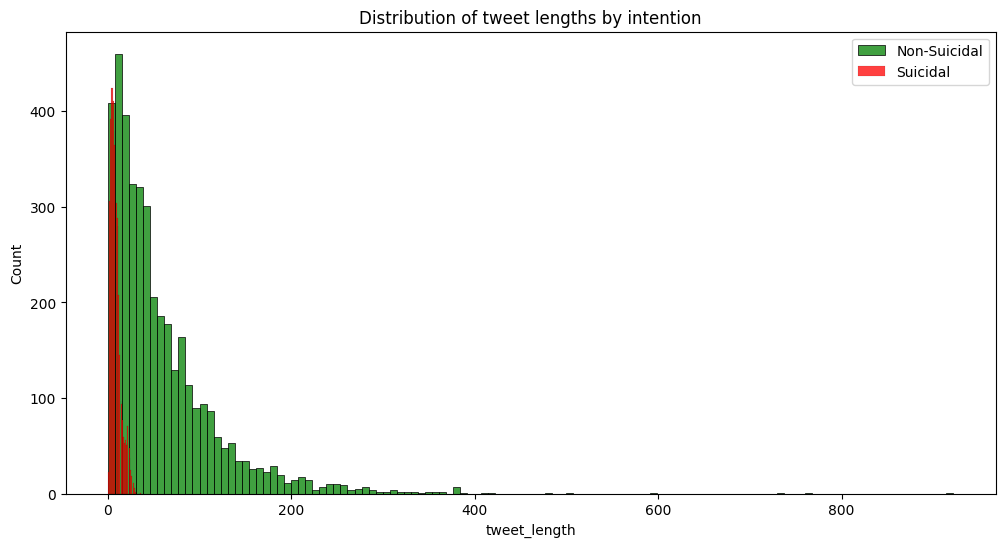

In [21]:
# visualize the distribution of tweet lengths by intention
raw_df['tweet_length'] = raw_df['cleaned_tweet'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(raw_df[raw_df['intention'] == 1]['tweet_length'], ax=ax, color='green', label='Non-Suicidal')
sns.histplot(raw_df[raw_df['intention'] == 0]['tweet_length'], ax=ax, color='red', label='Suicidal')
ax.set_title('Distribution of tweet lengths by intention')
ax.legend()
plt.show()

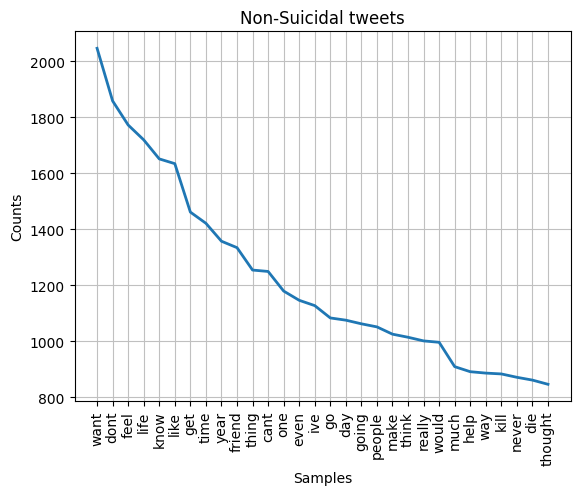

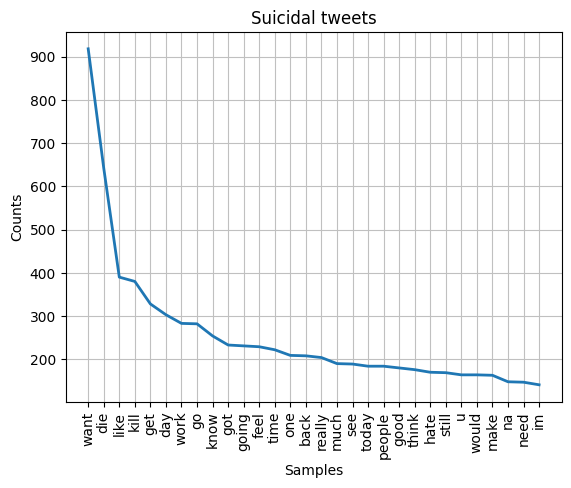

In [22]:
# visualize the distribution of word frequencies by intention
pos_tweets = ' '.join(raw_df[raw_df['intention'] == 1]['cleaned_tweet'])
neg_tweets = ' '.join(raw_df[raw_df['intention'] == 0]['cleaned_tweet'])

pos_freq_dist = FreqDist(word_tokenize(pos_tweets))
neg_freq_dist = FreqDist(word_tokenize(neg_tweets))

pos_freq_dist.plot(30, title='Non-Suicidal tweets', cumulative=False)
neg_freq_dist.plot(30, title='Suicidal tweets', cumulative=False)


### Train Test Split

In [23]:
X = raw_df['cleaned_tweet']
y = raw_df['intention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_val)

In [24]:
class TweetDataset(Dataset):
    def __init__(self, df, max_len):
        self.df = df
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tweet = self.df.iloc[idx]['cleaned_tweet']
        label = self.df.iloc[idx]['intention']

        return {
            'tweet': tweet,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [25]:
train_dataset = TweetDataset(pd.concat([X_train, y_train], axis=1), max_len=50)
test_dataset = TweetDataset(pd.concat([X_test, y_test], axis=1), max_len=50)

In [26]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## Creating Embedding Matrix Using word2vec

In [27]:
word2vec_path = '/kaggle/working/word2vec-google-news-300'

In [28]:
# download and save the word2vec model
word2vec_model = gensim.downloader.load('word2vec-google-news-300', return_path=False)

[=================================================-] 99.5% 1653.8/1662.8MB downloaded


In [29]:
word2vec_model.save(word2vec_path)

In [30]:
# load the word2vec model
# word2vec_model = KeyedVectors.load(word2vec_path)

## Implementing the models

### loss and accuracy plots during training

In [31]:
def plot_training_summary(title, loss_vals, accuracy_vals, epochs):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + " loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), accuracy_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title + " accuracy")

    plt.tight_layout()
    plt.show()

### Training loop

In [32]:
def train_tweet_classifier(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=20):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        print(f'---------- Epoch {epoch+1}/{num_epochs} ----------')
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm.tqdm(train_dataloader):
            optimizer.zero_grad()

            tweet = batch['tweet']
            label = batch['label'].to(device)
            label = label.float()

            # tweet = tweet.to(device)
            # label = label.to(device)

            outputs = model(tweet)
            outputs = outputs.squeeze(1)
            # print(f'shape of outputs: {outputs.shape}\nshape of label: {label.shape}')
            # print(f'outputs: {outputs}\nlabel: {label}')
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred_labels = torch.sigmoid(outputs)
            pred_labels = torch.round(pred_labels)
            train_acc += (pred_labels == label).sum().item()
            # train_acc += (outputs.argmax(1) == label).sum().item()

        train_loss /= len(train_dataloader.dataset)
        train_acc /= len(train_dataloader.dataset)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm.tqdm(test_dataloader):
                tweet = batch['tweet']
                label = batch['label'].to(device)
                label = label.float()

                # tweet = tweet.to(device)
                # label = label.to(device)

                outputs = model(tweet)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, label)

                test_loss += loss.item()
                pred_labels = torch.sigmoid(outputs)
                pred_labels = torch.round(pred_labels)
                test_acc += (pred_labels == label).sum().item()
                # test_acc += (outputs.argmax(1) == label).sum().item()

        test_loss /= len(test_dataloader.dataset)
        test_acc /= len(test_dataloader.dataset)

        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training loss: {train_loss:.4f} | Training accuracy: {train_acc:.4f}')
        print(f'Testing loss: {test_loss:.4f} | Testing accuracy: {test_acc:.4f}')
        print()

    return train_losses, train_accs, test_losses, test_accs

### LSTM

In [33]:
class TweetClassifier_LSTM(nn.Module):
    def __init__(self, word2vec_model, hidden_dim, output_dim, n_layers, bidirectional, dropout, max_len=50):
        super().__init__()

        self.max_len = max_len
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout

        self.hidden = torch.zeros(2 * n_layers, batch_size, hidden_dim).to(device)
        self.cell = torch.zeros(2 * n_layers, batch_size, hidden_dim).to(device)

        vocab_size, embedding_dim = len(word2vec_model.key_to_index), word2vec_model.vector_size
        weights = torch.FloatTensor(word2vec_model.vectors)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_batch):
        padded_batch = self.tokenize_and_pad(text_batch)
        # print(f'size: {len(padded_batch)},\npadded_batch: {padded_batch}\n')
        text = torch.tensor([[word2vec_model.key_to_index[token] if token in word2vec_model.key_to_index else 0 for token in tokens] for tokens in padded_batch])
        # print(f'size: {text.size()},\ntext: {text}\n')
        text = text.to(device)
        # text = text.unsqueeze(1).to(device)
        # print(f'size: {text.size()},\ntext: {text}\n')
        embedded = self.embedding(text)
        # print(f'shape: {embedded.shape},\nembedded: {embedded}\n')
        output, (hidden, cell) = self.lstm(embedded, (self.hidden, self.cell))
        # print(f'shape: {output.shape},\noutput: {output}\n')
        # print(f'shape: {hidden.shape},\nhidden: {hidden}\n')
        # print(f'shape: {cell.shape},\ncell: {cell}\n')
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # print(f'shape: {hidden.shape},\nhidden: {hidden}\n')
        return self.fc(hidden.squeeze(0))
    
    def tokenize_and_pad(self, text_batch):
        # print(f'size: {len(text_batch)},\ntext_batch: {text_batch}\n')
        tokens_batch = [word_tokenize(text) for text in text_batch]
        # print(f'size: {len(tokens_batch)},\ntokens_batch: {tokens_batch}\n')
        padded_batch = []
        for tokens in tokens_batch:
            if len(tokens) > self.max_len:
                padded_batch.append(tokens[:self.max_len])
            else:
                padded_batch.append(tokens + ['<pad>'] * (self.max_len - len(tokens)))
        return padded_batch

In [34]:
tweet_classifier_LSMT = TweetClassifier_LSTM(word2vec_model, hidden_dim=256, output_dim=1, n_layers=2, bidirectional=True, dropout=0.5)
tweet_classifier_LSMT = tweet_classifier_LSMT.to(device)

### Training the model

In [35]:
criterion_LSMT = nn.BCEWithLogitsLoss()
optimizer_LSMT = optim.Adam(tweet_classifier_LSMT.parameters())
num_epochs = 10

train_losses_LSMT, train_accs_LSMT, test_losses_LSMT, test_accs_LSMT = train_tweet_classifier(tweet_classifier_LSMT, train_dataloader, test_dataloader, criterion_LSMT, optimizer_LSMT, num_epochs=num_epochs)

---------- Epoch 1/10 ----------


100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Epoch 1/10:
Training loss: 0.0050 | Training accuracy: 0.8527
Testing loss: 0.0033 | Testing accuracy: 0.8931

---------- Epoch 2/10 ----------


100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Epoch 2/10:
Training loss: 0.0034 | Training accuracy: 0.9030
Testing loss: 0.0036 | Testing accuracy: 0.8925

---------- Epoch 3/10 ----------


100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Epoch 3/10:
Training loss: 0.0031 | Training accuracy: 0.9091
Testing loss: 0.0031 | Testing accuracy: 0.8925

---------- Epoch 4/10 ----------


100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Epoch 4/10:
Training loss: 0.0029 | Training accuracy: 0.9131
Testing loss: 0.0031 | Testing accuracy: 0.9056

---------- Epoch 5/10 ----------


100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Epoch 5/10:
Training loss: 0.0026 | Training accuracy: 0.9273
Testing loss: 0.0032 | Testing accuracy: 0.9010

---------- Epoch 6/10 ----------


100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Epoch 6/10:
Training loss: 0.0025 | Training accuracy: 0.9263
Testing loss: 0.0030 | Testing accuracy: 0.9005

---------- Epoch 7/10 ----------


100%|██████████| 27/27 [00:10<00:00,  2.69it/s]


Epoch 7/10:
Training loss: 0.0021 | Training accuracy: 0.9348
Testing loss: 0.0033 | Testing accuracy: 0.8879

---------- Epoch 8/10 ----------


100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Epoch 8/10:
Training loss: 0.0019 | Training accuracy: 0.9414
Testing loss: 0.0036 | Testing accuracy: 0.8982

---------- Epoch 9/10 ----------


100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Epoch 9/10:
Training loss: 0.0019 | Training accuracy: 0.9425
Testing loss: 0.0037 | Testing accuracy: 0.8942

---------- Epoch 10/10 ----------


100%|██████████| 27/27 [00:08<00:00,  3.09it/s]

Epoch 10/10:
Training loss: 0.0016 | Training accuracy: 0.9533
Testing loss: 0.0036 | Testing accuracy: 0.8965



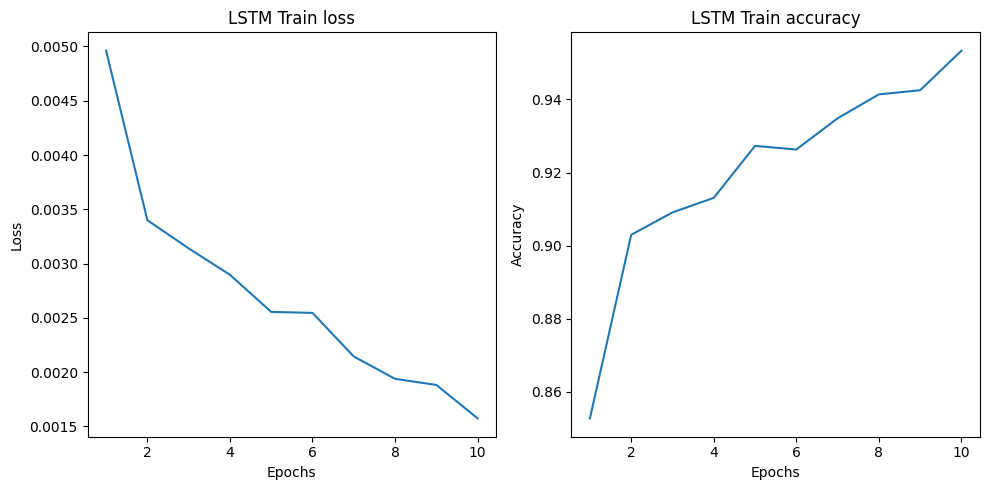

In [36]:
plot_training_summary('LSTM Train', train_losses_LSMT, train_accs_LSMT, num_epochs)

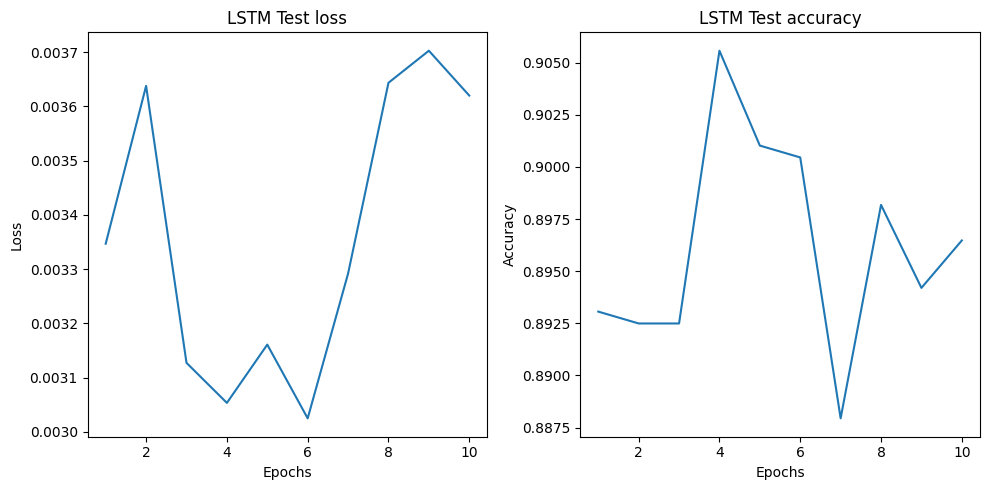

In [37]:
plot_training_summary('LSTM Test', test_losses_LSMT, test_accs_LSMT, num_epochs)

### 2-Layer LSTM

In [38]:
class TweetClassifier_2LSTM(nn.Module):
    def __init__(self, word2vec_model, hidden_dim, output_dim, n_layers, bidirectional, dropout, max_len=50):
        super().__init__()

        self.max_len = max_len
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout

        self.hidden = torch.zeros(2 * n_layers, batch_size, hidden_dim).to(device)
        self.cell = torch.zeros(2 * n_layers, batch_size, hidden_dim).to(device)

        vocab_size, embedding_dim = len(word2vec_model.key_to_index), word2vec_model.vector_size
        weights = torch.FloatTensor(word2vec_model.vectors)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_batch):
        padded_batch = self.tokenize_and_pad(text_batch)
        # print(f'size: {len(padded_batch)},\npadded_batch: {padded_batch}\n')
        text = torch.tensor([[word2vec_model.key_to_index[token] if token in word2vec_model.key_to_index else 0 for token in tokens] for tokens in padded_batch])
        # print(f'size: {text.size()},\ntext: {text}\n')
        text = text.to(device)
        # text = text.unsqueeze(1).to(device)
        # print(f'size: {text.size()},\ntext: {text}\n')
        embedded = self.embedding(text)
        # print(f'shape: {embedded.shape},\nembedded: {embedded}\n')
        output, (hidden, cell) = self.lstm1(embedded, (self.hidden, self.cell))
        # print(f'shape: {output.shape},\noutput: {output}\n')
        # print(f'shape: {hidden.shape},\nhidden: {hidden}\n')
        # print(f'shape: {cell.shape},\ncell: {cell}\n')
        output, (hidden, cell) = self.lstm2(output, (self.hidden, self.cell))
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # print(f'shape: {hidden.shape},\nhidden: {hidden}\n')
        return self.fc(hidden.squeeze(0))
    
    def tokenize_and_pad(self, text_batch):
        # print(f'size: {len(text_batch)},\ntext_batch: {text_batch}\n')
        tokens_batch = [word_tokenize(text) for text in text_batch]
        # print(f'size: {len(tokens_batch)},\ntokens_batch: {tokens_batch}\n')
        padded_batch = []
        for tokens in tokens_batch:
            if len(tokens) > self.max_len:
                padded_batch.append(tokens[:self.max_len])
            else:
                padded_batch.append(tokens + ['<pad>'] * (self.max_len - len(tokens)))
        return padded_batch

In [39]:
tweet_classifier_2LSMT = TweetClassifier_2LSTM(word2vec_model, hidden_dim=256, output_dim=1, n_layers=2, bidirectional=True, dropout=0.5)
tweet_classifier_2LSMT = tweet_classifier_2LSMT.to(device)

### Training the model

In [40]:
criterion_2LSMT = nn.BCEWithLogitsLoss()
optimizer_2LSMT = optim.Adam(tweet_classifier_2LSMT.parameters())
num_epochs = 10

train_losses_2LSMT, train_accs_2LSMT, test_losses_2LSMT, test_accs_2LSMT = train_tweet_classifier(tweet_classifier_2LSMT, train_dataloader, test_dataloader, criterion_2LSMT, optimizer_2LSMT, num_epochs=num_epochs)

---------- Epoch 1/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 1/10:
Training loss: 0.0055 | Training accuracy: 0.8227
Testing loss: 0.0042 | Testing accuracy: 0.8572

---------- Epoch 2/10 ----------


100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch 2/10:
Training loss: 0.0038 | Training accuracy: 0.8869
Testing loss: 0.0038 | Testing accuracy: 0.8766

---------- Epoch 3/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 3/10:
Training loss: 0.0033 | Training accuracy: 0.9061
Testing loss: 0.0033 | Testing accuracy: 0.8896

---------- Epoch 4/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 4/10:
Training loss: 0.0030 | Training accuracy: 0.9115
Testing loss: 0.0051 | Testing accuracy: 0.8345

---------- Epoch 5/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 5/10:
Training loss: 0.0034 | Training accuracy: 0.9040
Testing loss: 0.0036 | Testing accuracy: 0.8760

---------- Epoch 6/10 ----------


100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Epoch 6/10:
Training loss: 0.0029 | Training accuracy: 0.9151
Testing loss: 0.0034 | Testing accuracy: 0.8788

---------- Epoch 7/10 ----------


100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Epoch 7/10:
Training loss: 0.0024 | Training accuracy: 0.9300
Testing loss: 0.0032 | Testing accuracy: 0.8902

---------- Epoch 8/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 8/10:
Training loss: 0.0022 | Training accuracy: 0.9384
Testing loss: 0.0033 | Testing accuracy: 0.8970

---------- Epoch 9/10 ----------


100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Epoch 9/10:
Training loss: 0.0020 | Training accuracy: 0.9432
Testing loss: 0.0037 | Testing accuracy: 0.8976

---------- Epoch 10/10 ----------


100%|██████████| 27/27 [00:17<00:00,  1.54it/s]

Epoch 10/10:
Training loss: 0.0019 | Training accuracy: 0.9417
Testing loss: 0.0036 | Testing accuracy: 0.9010



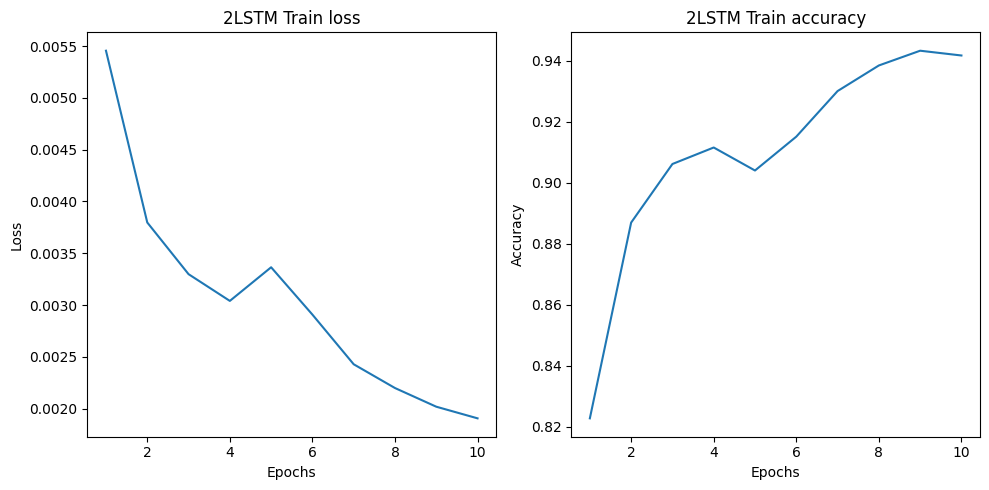

In [41]:
plot_training_summary('2LSTM Train', train_losses_2LSMT, train_accs_2LSMT, num_epochs)

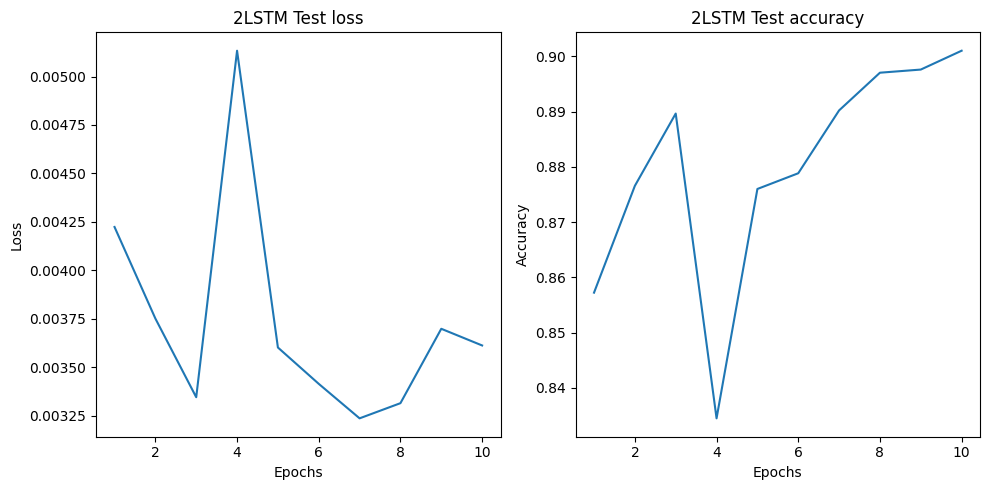

In [42]:
plot_training_summary('2LSTM Test', test_losses_2LSMT, test_accs_2LSMT, num_epochs)

### CNN + 2-Layer LSTM

In [43]:
class CNN_2LSTM(nn.Module):
    def __init__(self, word2vec_model, hidden_dim, output_dim, n_layers, bidirectional, dropout, filters=64, max_len=50):
        super().__init__()

        self.max_len = max_len
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.filters = filters

        self.hidden = torch.zeros(2 * n_layers, batch_size, hidden_dim).to(device)
        self.cell = torch.zeros(2 * n_layers, batch_size, hidden_dim).to(device)

        vocab_size, embedding_dim = len(word2vec_model.key_to_index), word2vec_model.vector_size
        weights = torch.FloatTensor(word2vec_model.vectors)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.conv = nn.Conv1d(embedding_dim, filters, kernel_size=3, padding='same')
        self.conv_activation = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv_flatten = nn.Flatten()
        self.conv_dropout = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(32, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_batch):
        padded_batch = self.tokenize_and_pad(text_batch)
        # print(f'size: {len(padded_batch)},\npadded_batch: {padded_batch}\n')
        text = torch.tensor([[word2vec_model.key_to_index[token] if token in word2vec_model.key_to_index else 0 for token in tokens] for tokens in padded_batch])
        # print(f'size: {text.size()},\ntext: {text}\n')
        text = text.to(device)
        # text = text.unsqueeze(1).to(device)
        # print(f'size: {text.size()},\ntext: {text}\n')
        embedded = self.embedding(text)
        # print(f'shape: {embedded.shape},\nembedded1: {embedded}\n')
        embedded = embedded.permute(0, 2, 1)
        # print(f'shape: {embedded.shape},\nembedded2: {embedded}\n')
        embedded = self.conv(embedded)
        # print(f'shape: {embedded.shape},\nembedded3: {embedded}\n')
        embedded = self.conv_activation(embedded)
        embedded = embedded.permute(0, 2, 1)
        # print(f'shape: {embedded.shape},\nembedded4: {embedded}\n')
        embedded = self.pool(embedded)
        # print(f'shape: {embedded.shape},\nembedded5: {embedded}\n')
        embedded = self.conv_flatten(embedded)
        # print(f'shape: {embedded.shape},\nembedded6: {embedded}\n')
        embedded = self.conv_dropout(embedded)
        # print(f'shape: {embedded.shape},\nembedded7: {embedded}\n')
        embedded = embedded.view(batch_size, self.max_len, -1)
        # print(f'shape: {embedded.shape},\nembedded8: {embedded}\n')
        output, (hidden, cell) = self.lstm1(embedded, (self.hidden, self.cell))
        # print(f'shape: {output.shape},\noutput: {output}\n')
        # print(f'shape: {hidden.shape},\nhidden: {hidden}\n')
        # print(f'shape: {cell.shape},\ncell: {cell}\n')
        output, (hidden, cell) = self.lstm2(output, (self.hidden, self.cell))
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # print(f'shape: {hidden.shape},\nhidden: {hidden}\n')
        return self.fc(hidden.squeeze(0))
    
    def tokenize_and_pad(self, text_batch):
        # print(f'size: {len(text_batch)},\ntext_batch: {text_batch}\n')
        tokens_batch = [word_tokenize(text) for text in text_batch]
        # print(f'size: {len(tokens_batch)},\ntokens_batch: {tokens_batch}\n')
        padded_batch = []
        for tokens in tokens_batch:
            if len(tokens) > self.max_len:
                padded_batch.append(tokens[:self.max_len])
            else:
                padded_batch.append(tokens + ['<pad>'] * (self.max_len - len(tokens)))
        return padded_batch
    

In [44]:
tweet_classifier_CNN_2LSMT = CNN_2LSTM(word2vec_model, hidden_dim=256, output_dim=1, n_layers=2, bidirectional=True, dropout=0.5)
tweet_classifier_CNN_2LSMT = tweet_classifier_CNN_2LSMT.to(device)

### Training the model

In [45]:
criterion_CNN_2LSMT = nn.BCEWithLogitsLoss()
optimizer_CNN_2LSMT = optim.Adam(tweet_classifier_CNN_2LSMT.parameters())
num_epochs = 10

train_losses_CNN_2LSMT, train_accs_CNN_2LSMT, test_losses_CNN_2LSMT, test_accs_CNN_2LSMT = train_tweet_classifier(tweet_classifier_CNN_2LSMT, train_dataloader, test_dataloader, criterion_CNN_2LSMT, optimizer_CNN_2LSMT, num_epochs=num_epochs)

---------- Epoch 1/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 1/10:
Training loss: 0.0061 | Training accuracy: 0.7999
Testing loss: 0.0042 | Testing accuracy: 0.8675

---------- Epoch 2/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.64it/s]


Epoch 2/10:
Training loss: 0.0044 | Training accuracy: 0.8641
Testing loss: 0.0043 | Testing accuracy: 0.8470

---------- Epoch 3/10 ----------


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch 3/10:
Training loss: 0.0037 | Training accuracy: 0.8853
Testing loss: 0.0037 | Testing accuracy: 0.8817

---------- Epoch 4/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.65it/s]


Epoch 4/10:
Training loss: 0.0034 | Training accuracy: 0.8973
Testing loss: 0.0032 | Testing accuracy: 0.8914

---------- Epoch 5/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.65it/s]


Epoch 5/10:
Training loss: 0.0029 | Training accuracy: 0.9125
Testing loss: 0.0032 | Testing accuracy: 0.8970

---------- Epoch 6/10 ----------


100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Epoch 6/10:
Training loss: 0.0026 | Training accuracy: 0.9230
Testing loss: 0.0031 | Testing accuracy: 0.8959

---------- Epoch 7/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 7/10:
Training loss: 0.0023 | Training accuracy: 0.9270
Testing loss: 0.0030 | Testing accuracy: 0.8976

---------- Epoch 8/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 8/10:
Training loss: 0.0022 | Training accuracy: 0.9326
Testing loss: 0.0035 | Testing accuracy: 0.8970

---------- Epoch 9/10 ----------


100%|██████████| 27/27 [00:19<00:00,  1.42it/s]


Epoch 9/10:
Training loss: 0.0020 | Training accuracy: 0.9373
Testing loss: 0.0036 | Testing accuracy: 0.9005

---------- Epoch 10/10 ----------


100%|██████████| 27/27 [00:16<00:00,  1.60it/s]

Epoch 10/10:
Training loss: 0.0021 | Training accuracy: 0.9371
Testing loss: 0.0032 | Testing accuracy: 0.9005



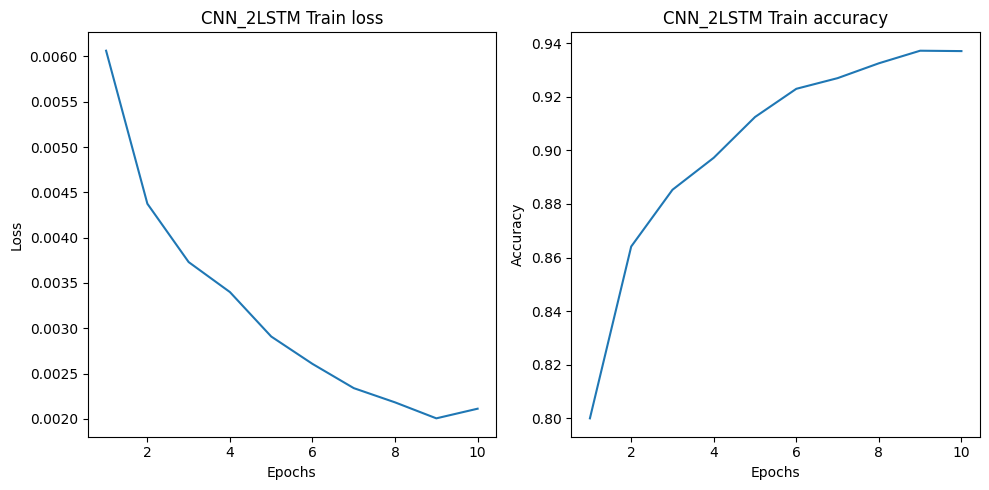

In [46]:
plot_training_summary('CNN_2LSTM Train', train_losses_CNN_2LSMT, train_accs_CNN_2LSMT, num_epochs)

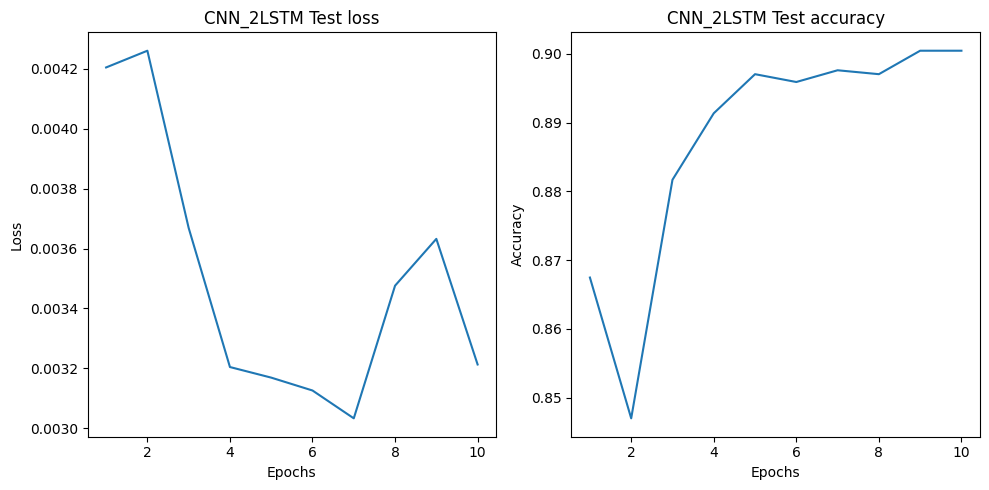

In [47]:
plot_training_summary('CNN_2LSTM Test', test_losses_CNN_2LSMT, test_accs_CNN_2LSMT, num_epochs)